In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l1
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import datasets
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
np.random.seed(1)

In [3]:
#pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

secondary_mushroom = fetch_ucirepo(id=848) 
# data (as pandas dataframes) 
x = secondary_mushroom.data.features 
y = secondary_mushroom.data.targets
# fetch dataset 

data = pd.DataFrame(x)
data.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


In [4]:
print(data.info()) # data info
print(data.describe(include='all'))  # Describe to include categorical data
print(data.isnull().sum())  # Check for missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          61069 non-null  float64
 1   cap-shape             61069 non-null  object 
 2   cap-surface           46949 non-null  object 
 3   cap-color             61069 non-null  object 
 4   does-bruise-or-bleed  61069 non-null  object 
 5   gill-attachment       51185 non-null  object 
 6   gill-spacing          36006 non-null  object 
 7   gill-color            61069 non-null  object 
 8   stem-height           61069 non-null  float64
 9   stem-width            61069 non-null  float64
 10  stem-root             9531 non-null   object 
 11  stem-surface          22945 non-null  object 
 12  stem-color            61069 non-null  object 
 13  veil-type             3177 non-null   object 
 14  veil-color            7413 non-null   object 
 15  has-ring           

In [5]:
#Filling NaN values with median or more if nor float or integer
for column in data.columns:
    if data[column].dtype == 'float64' or data[column].dtype == 'int64':
        data[column].fillna(data[column].median(), inplace=True)
    else:
        data[column].fillna(data[column].mode()[0], inplace=True)

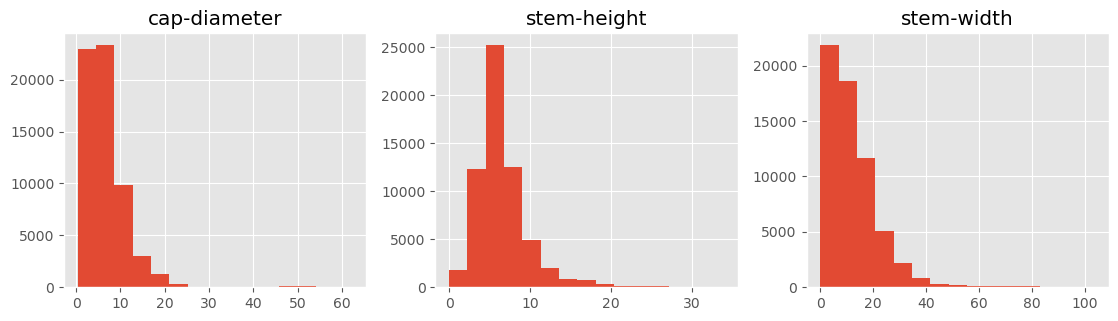

In [6]:
#Numeric features
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns].hist(bins=15, figsize=(15, 6), layout=(2, 4))
plt.tight_layout()
plt.show()

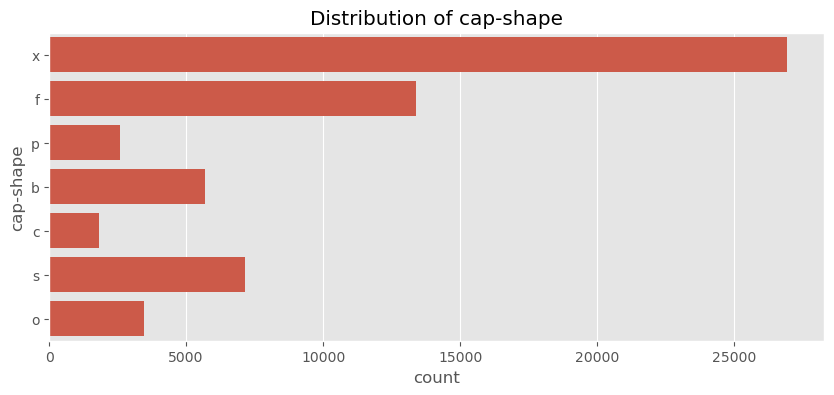

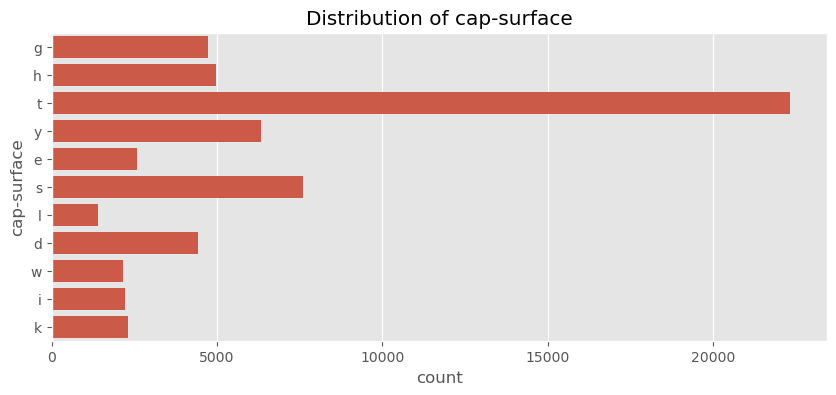

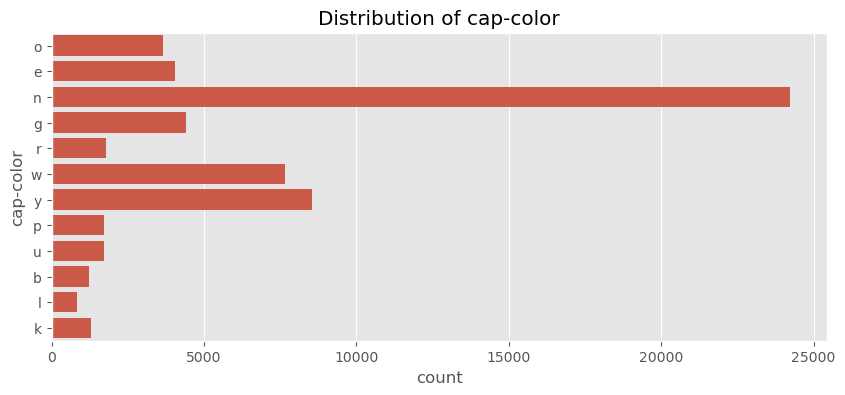

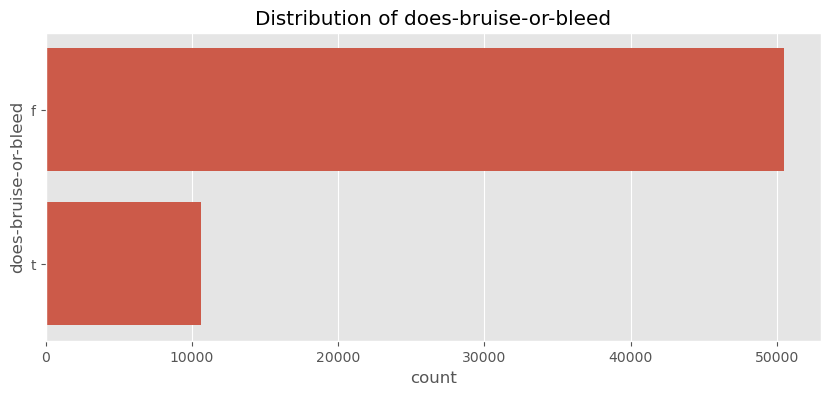

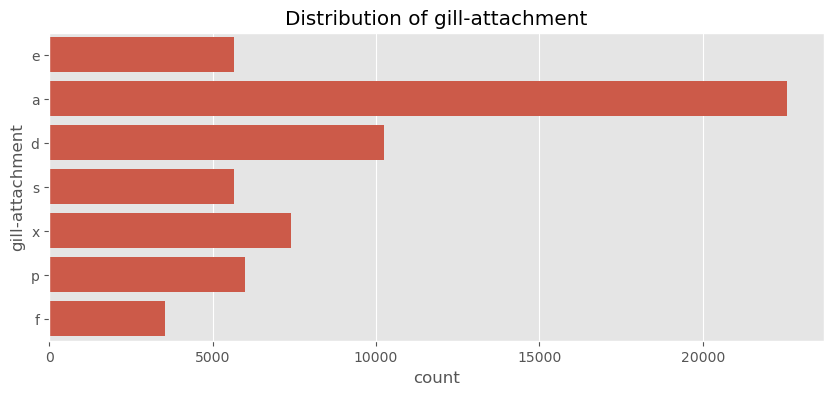

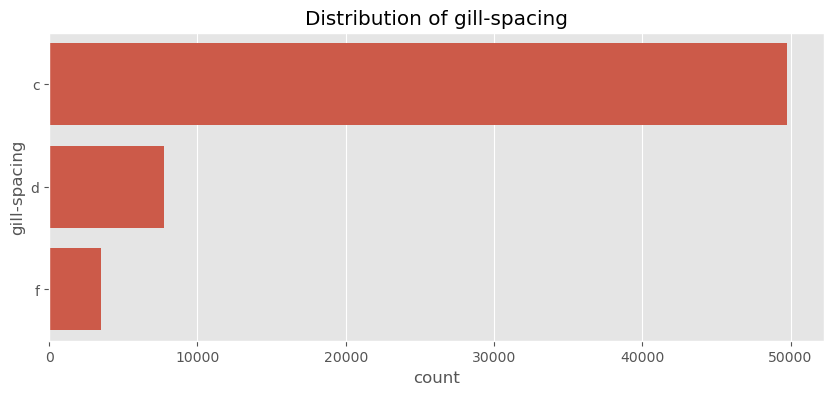

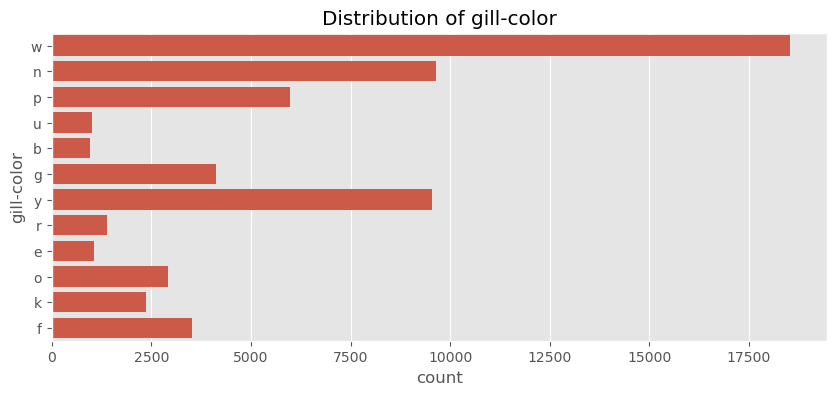

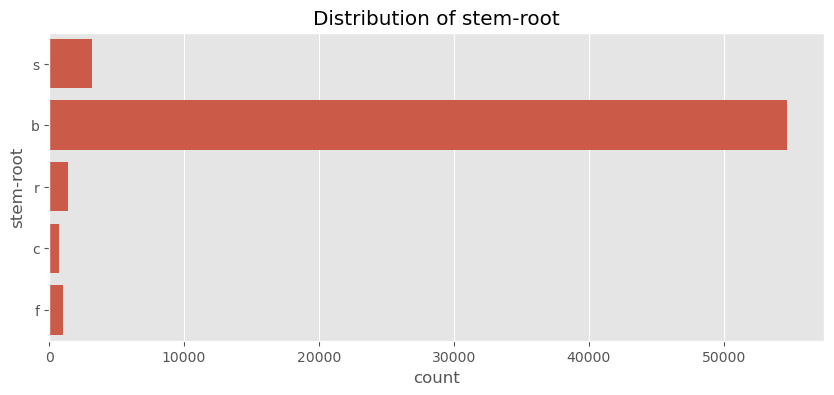

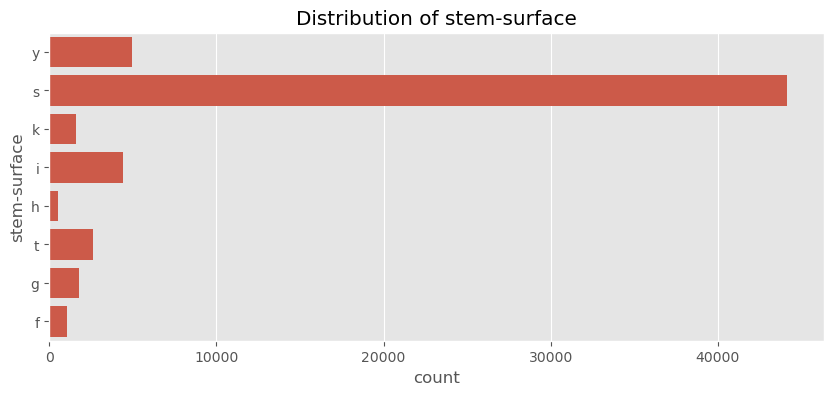

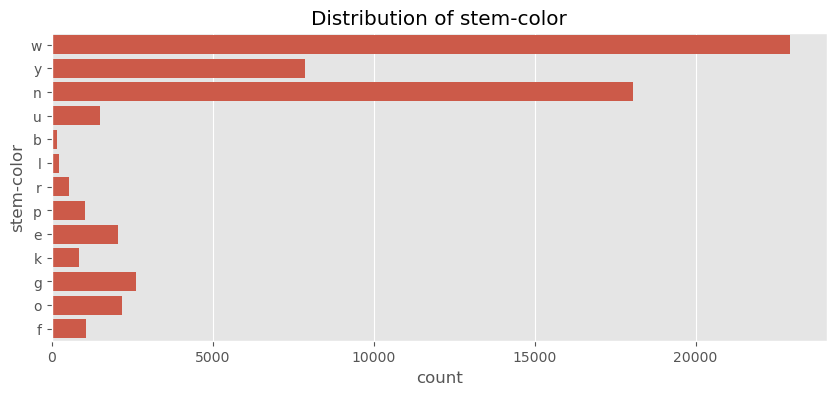

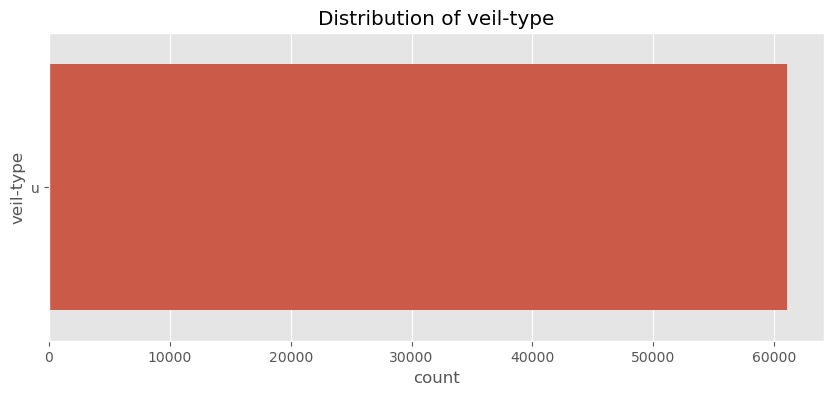

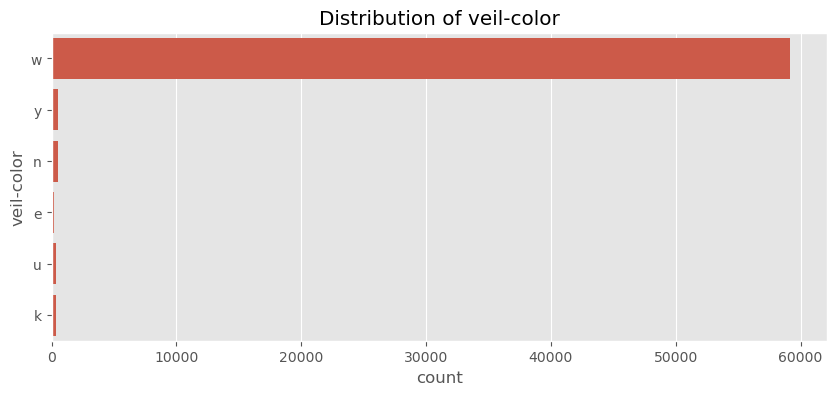

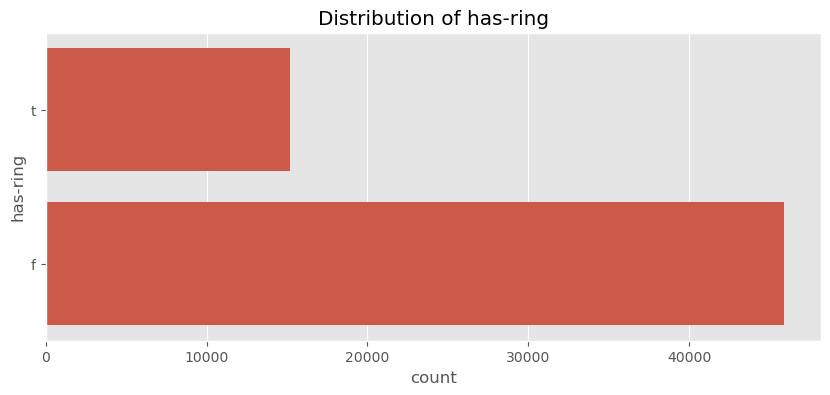

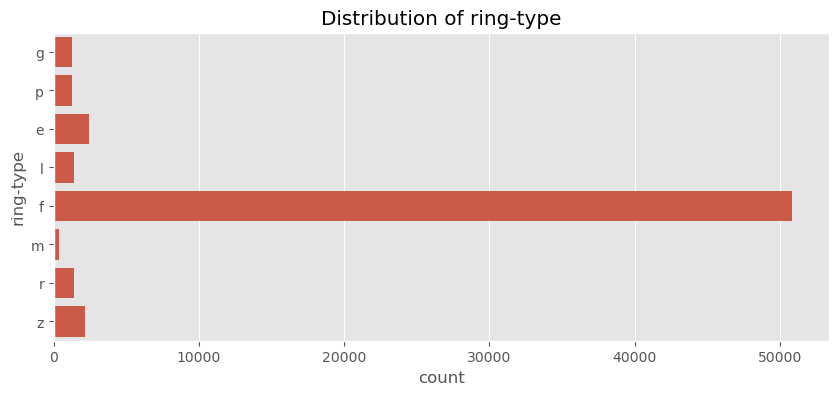

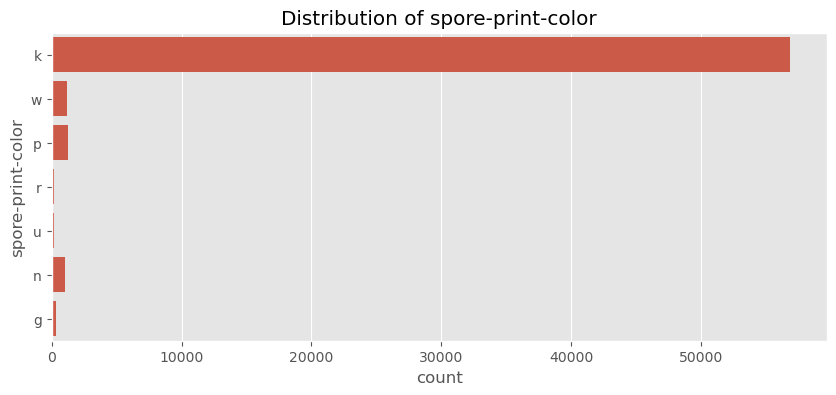

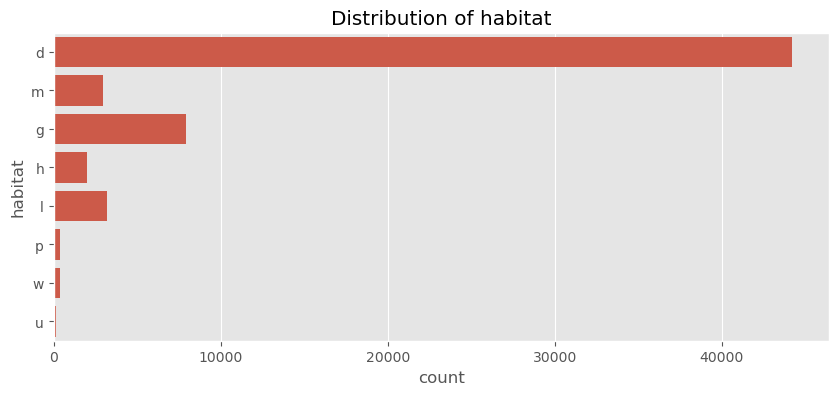

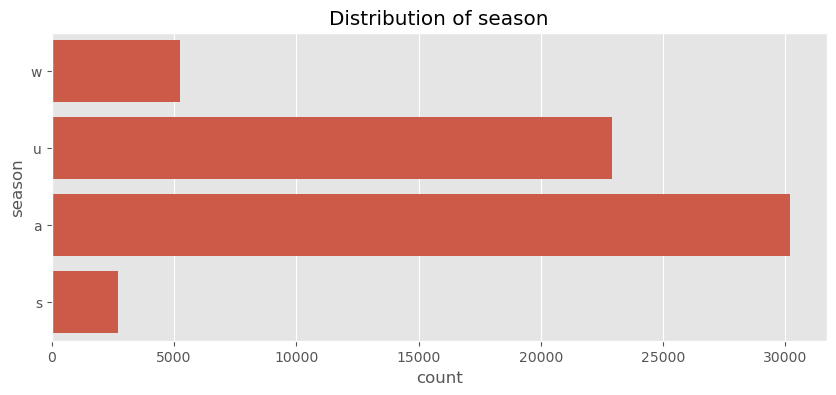

In [7]:
# Categorical features
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(y=column, data=data)
    plt.title(f'Distribution of {column}')
    plt.show()

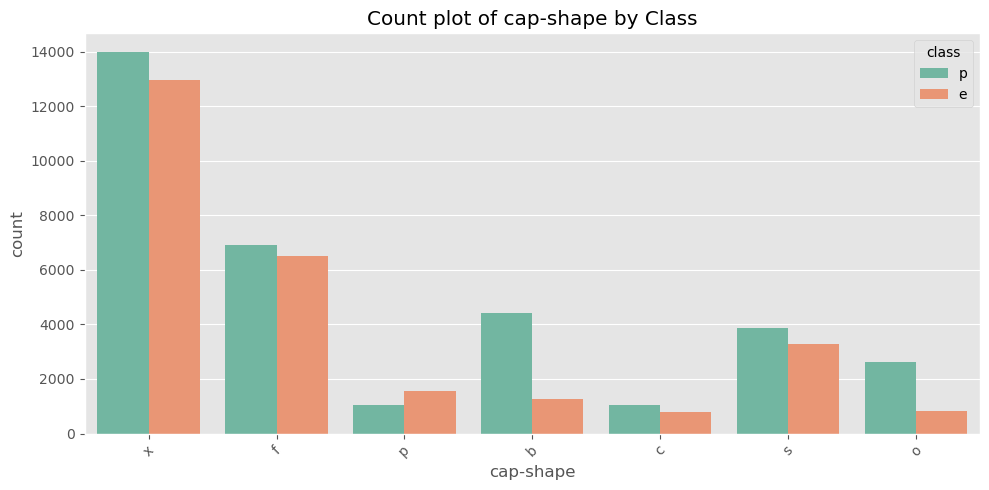

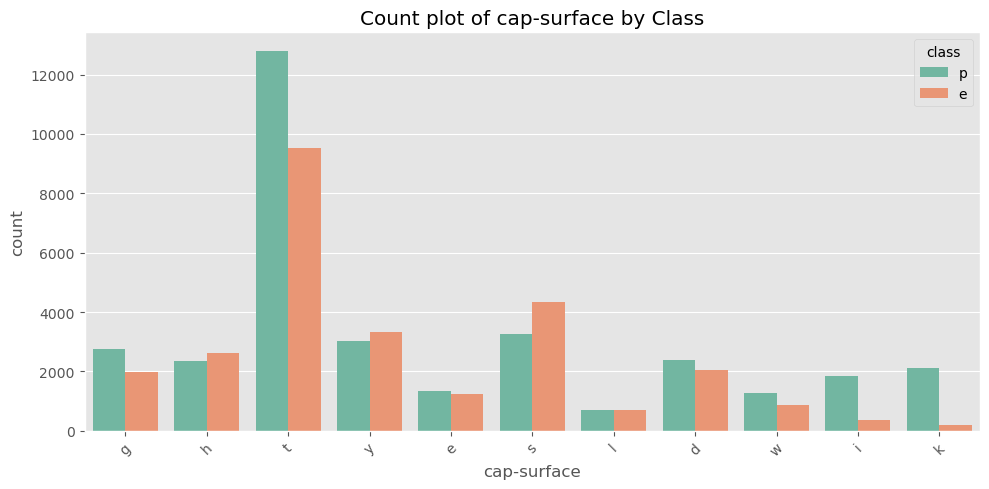

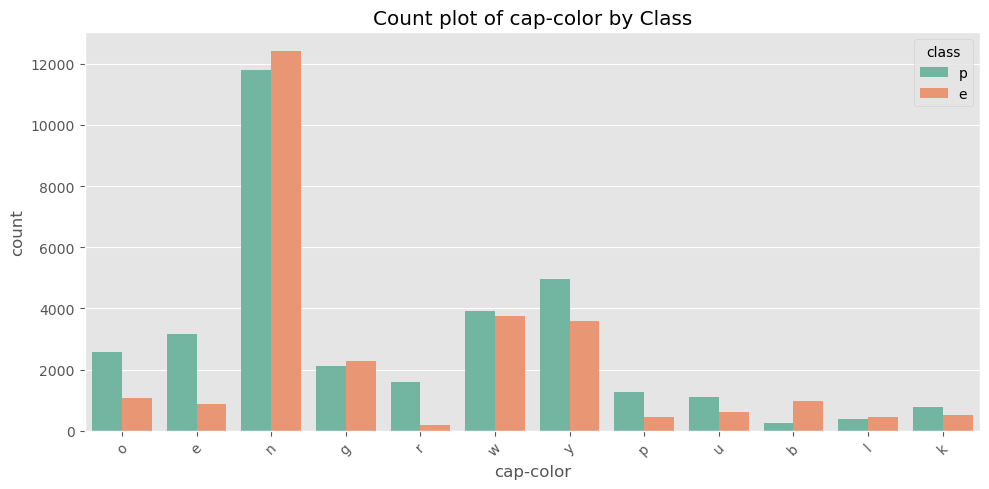

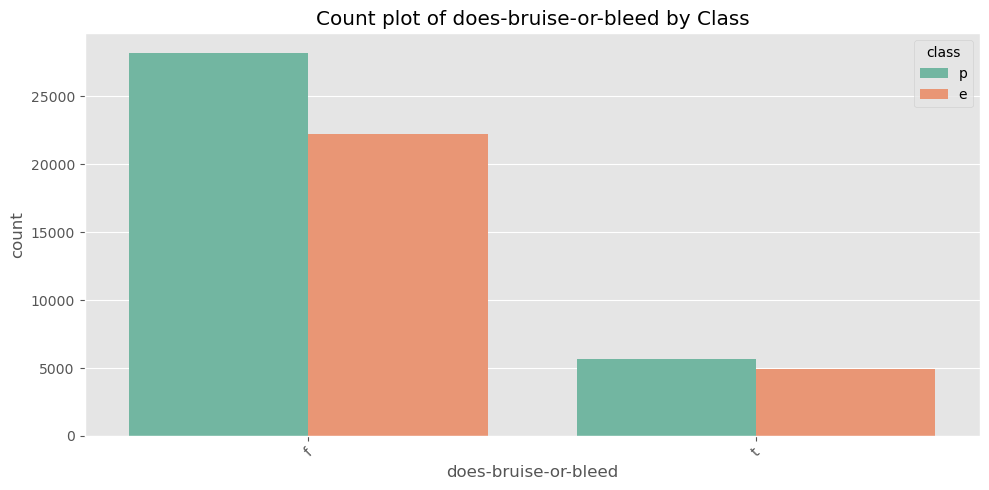

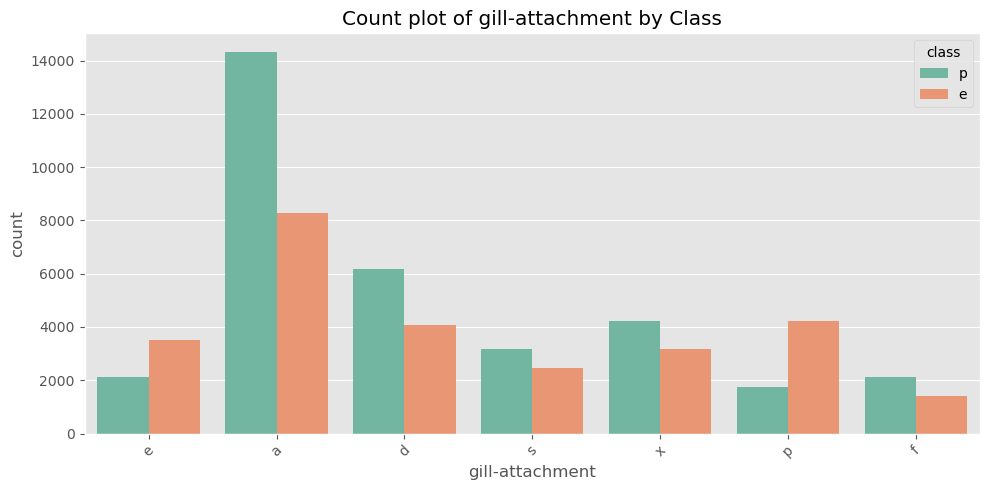

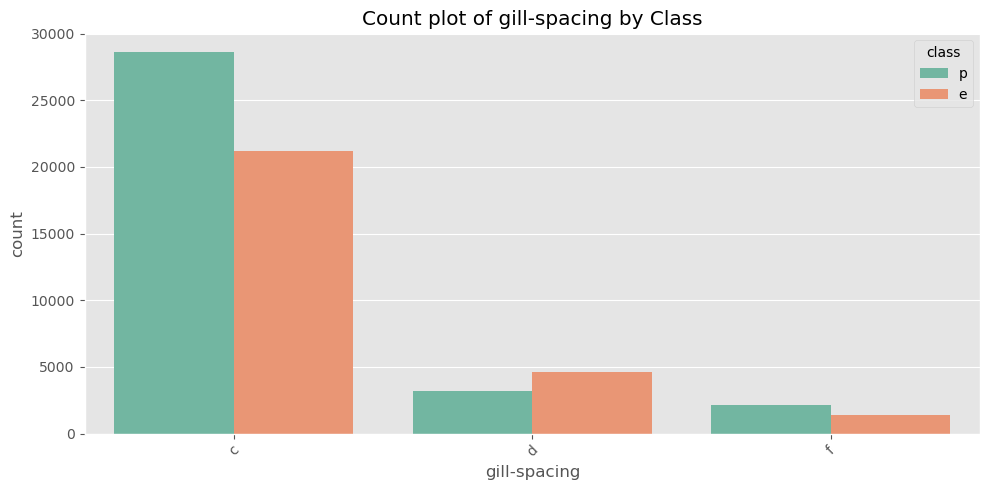

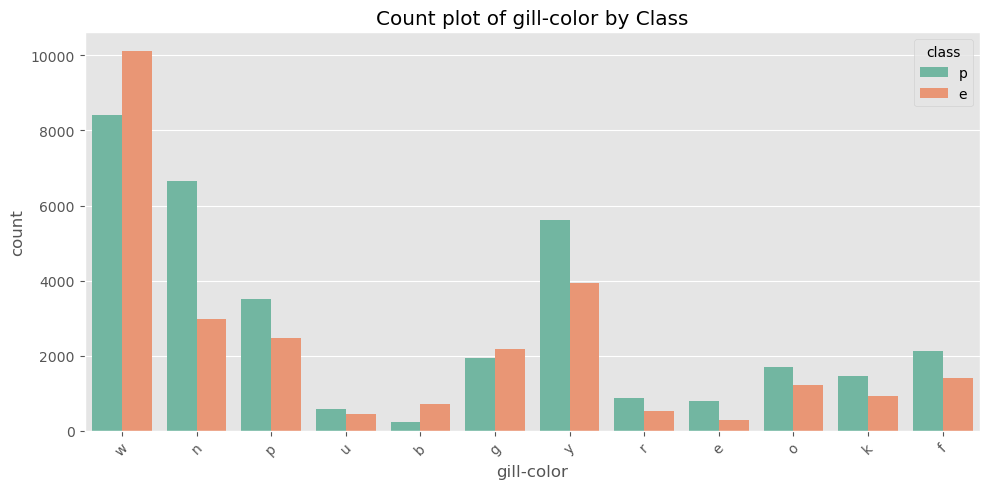

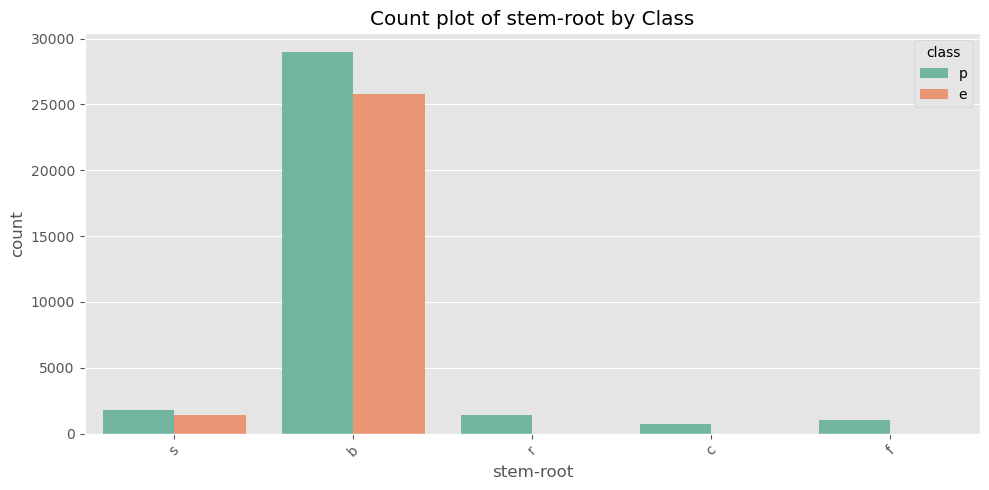

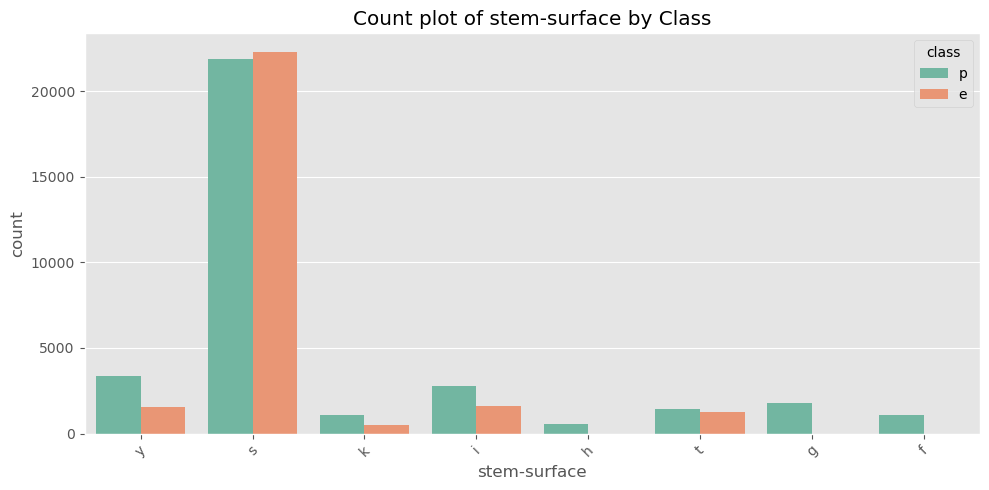

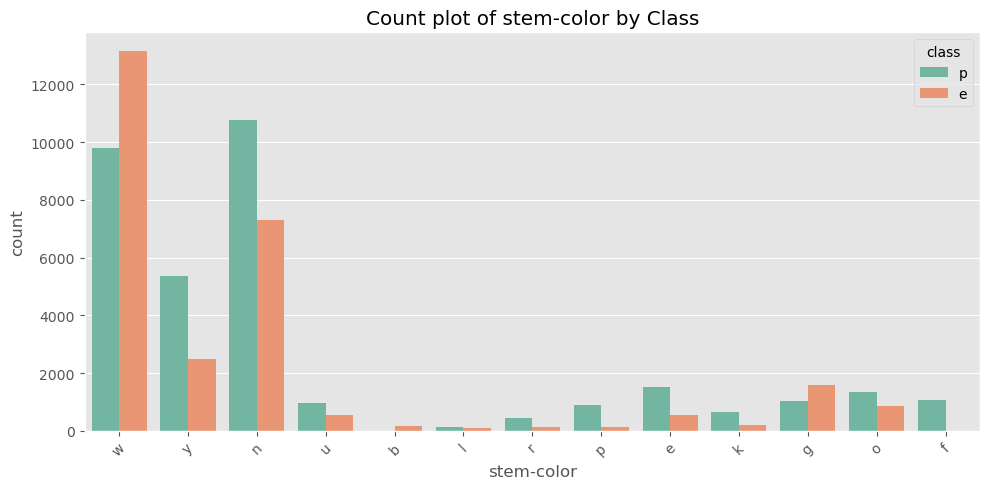

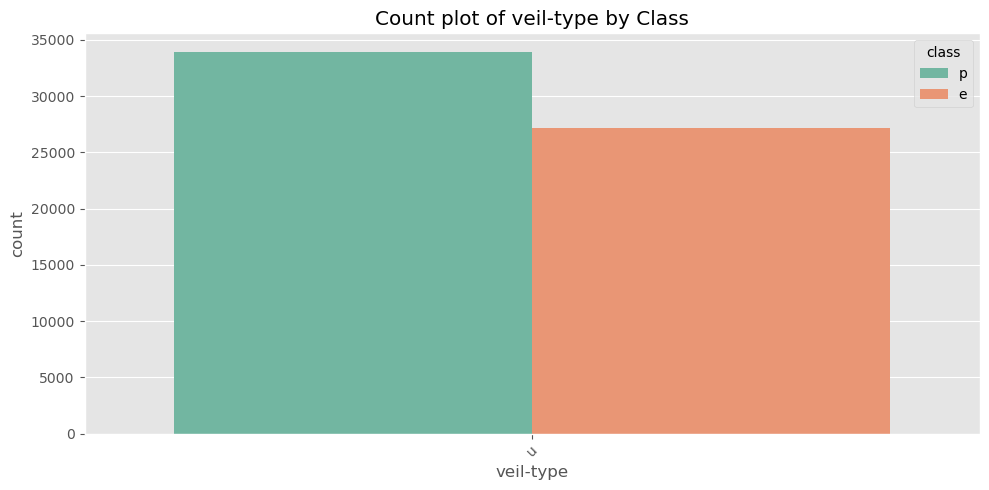

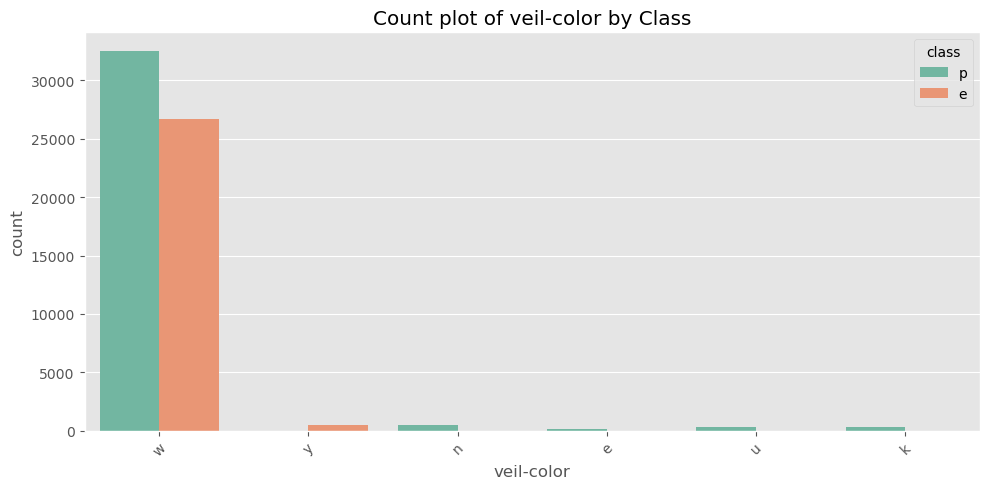

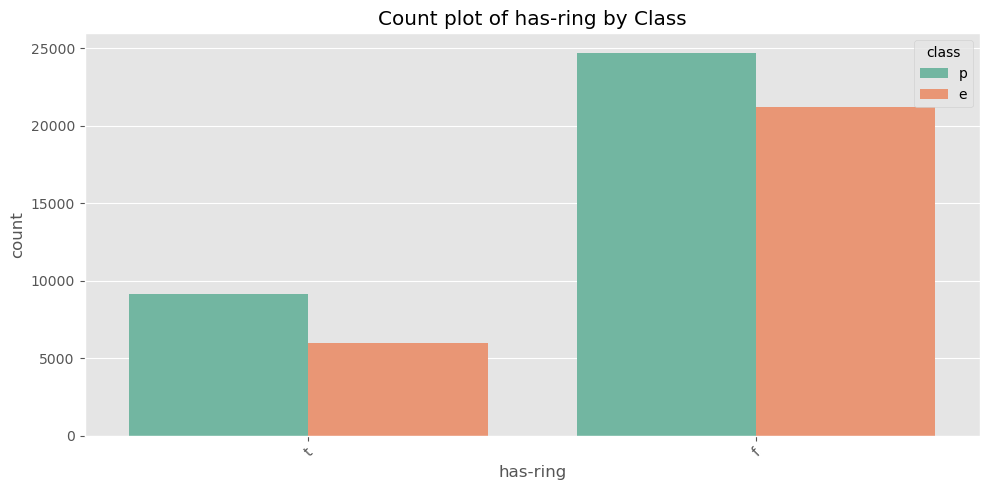

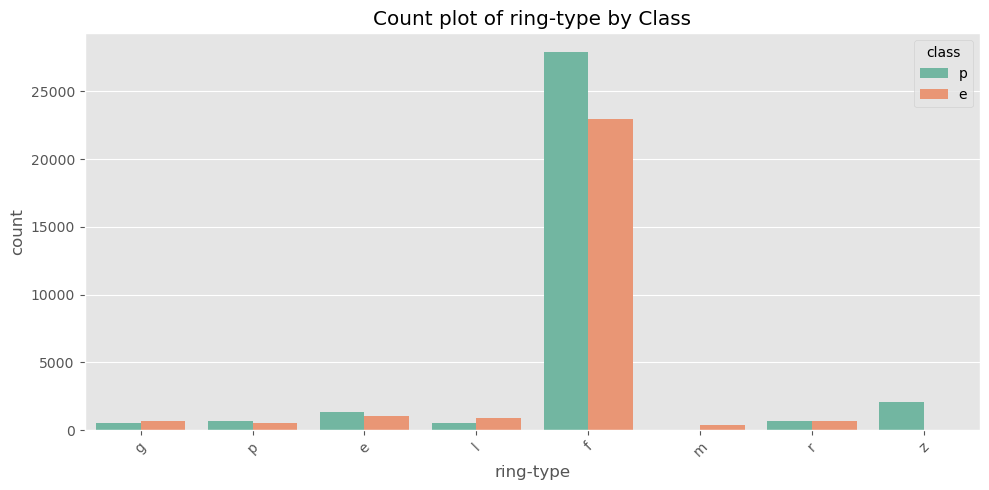

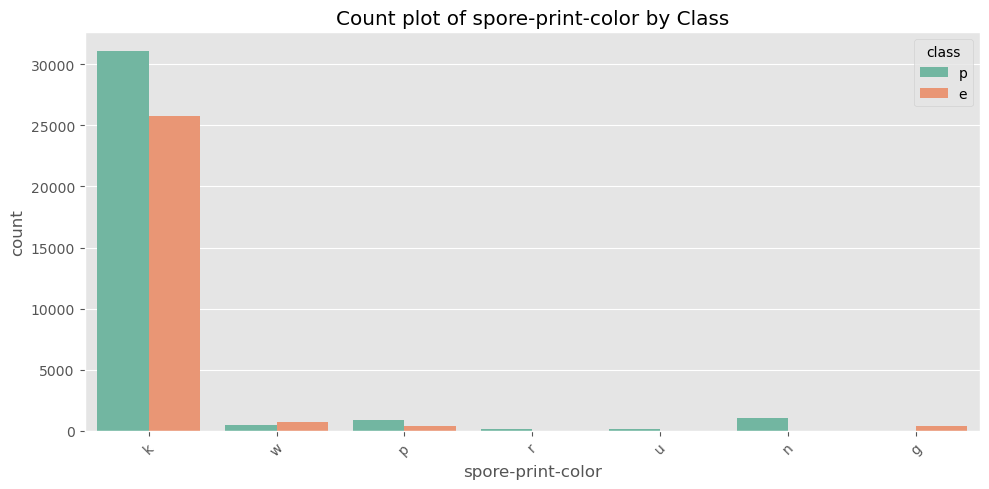

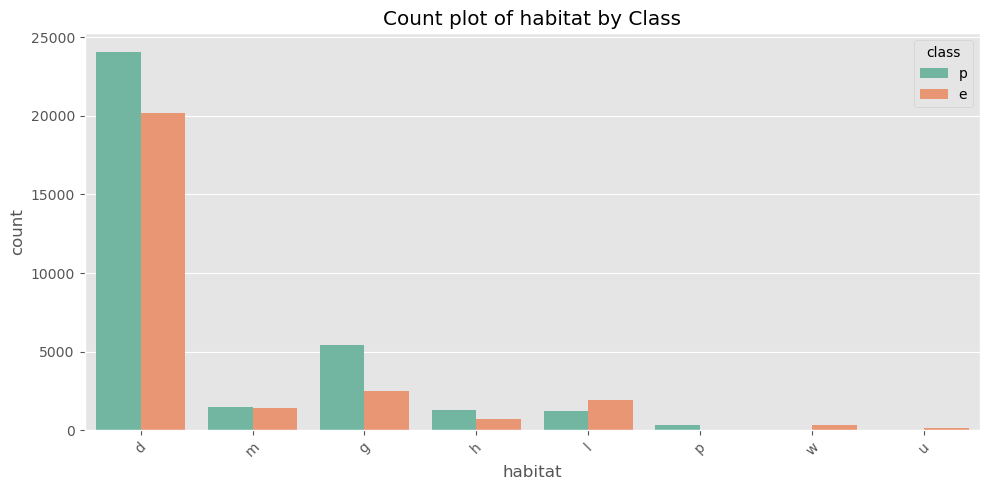

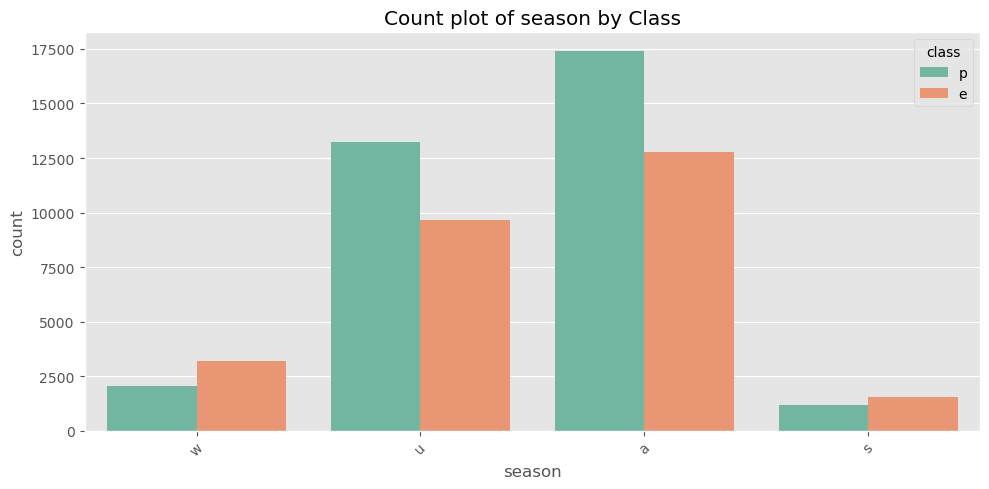

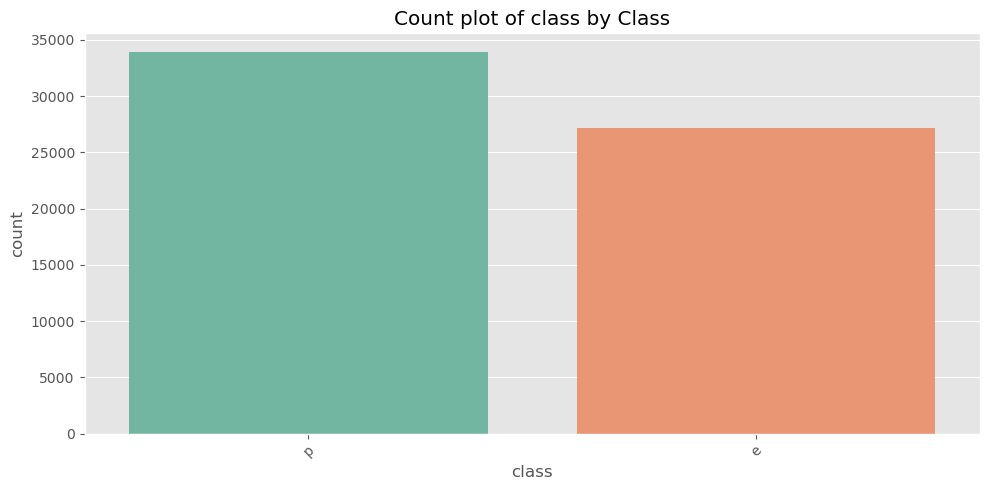

In [8]:
#adding data class
data['class'] = y
# Ensuring all categories are indeed categorical
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

# Creating count plots for categorical variables with hue='class'
for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=column, hue='class', data=data, palette='Set2')
    plt.title(f'Count plot of {column} by Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

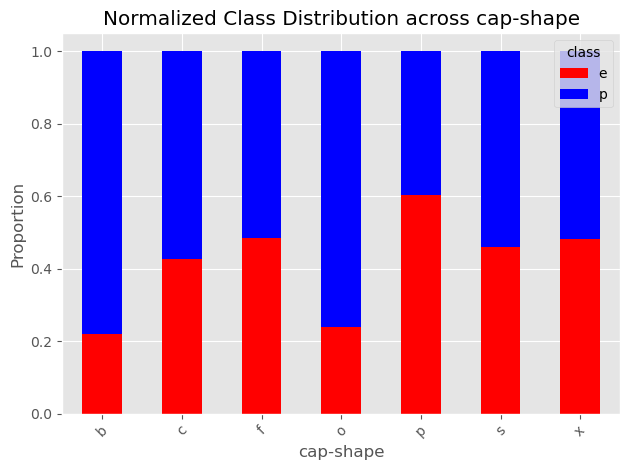

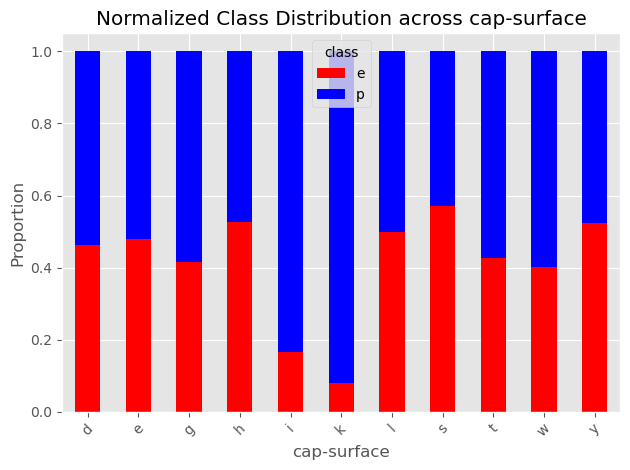

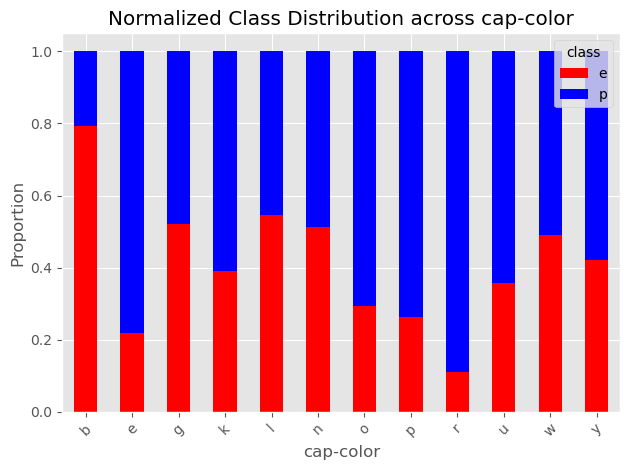

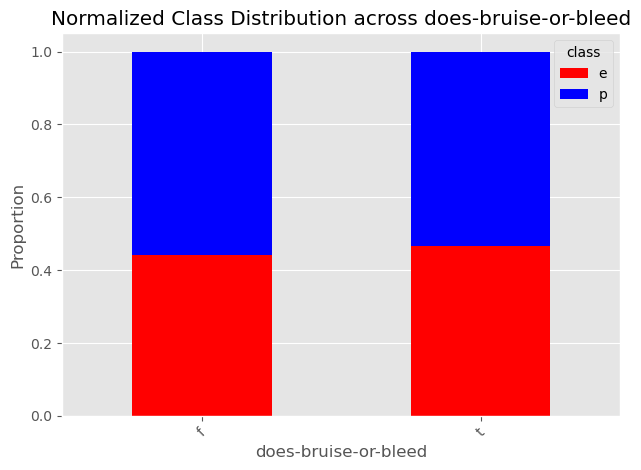

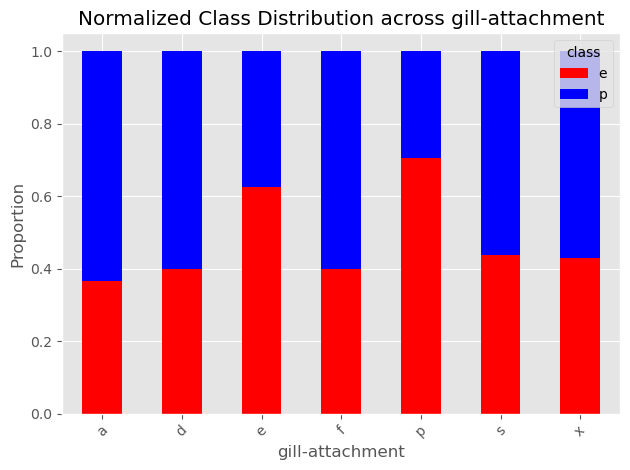

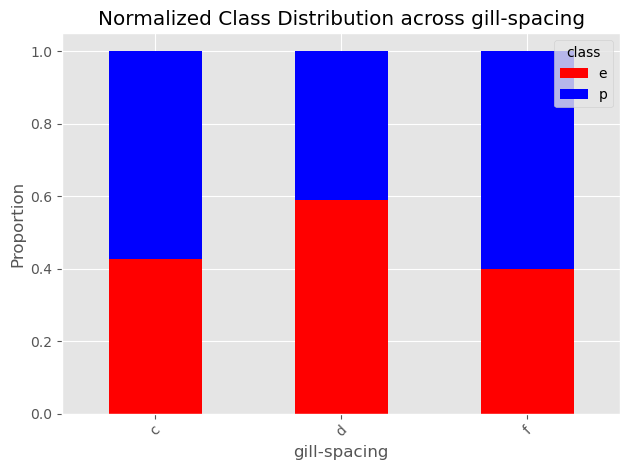

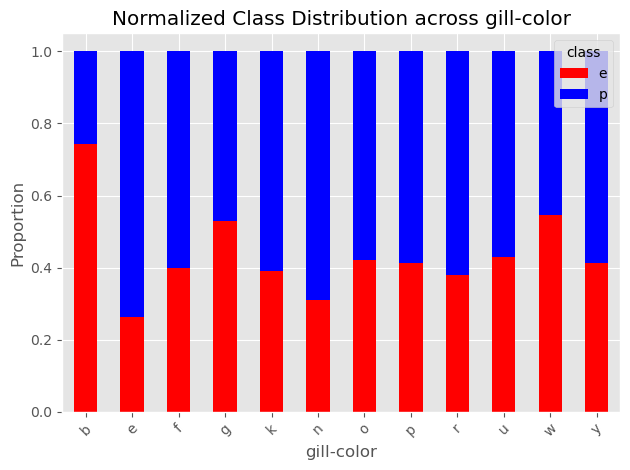

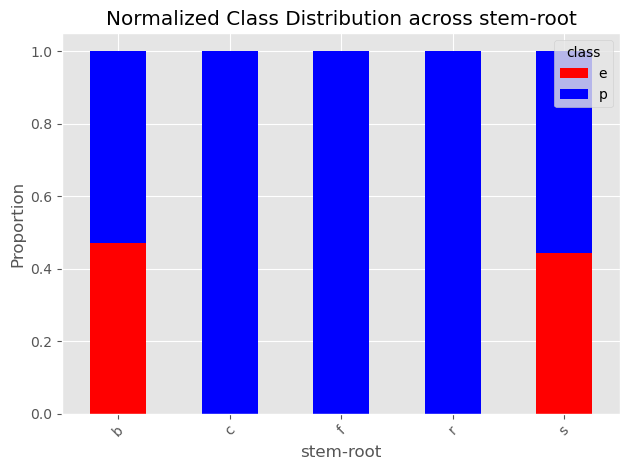

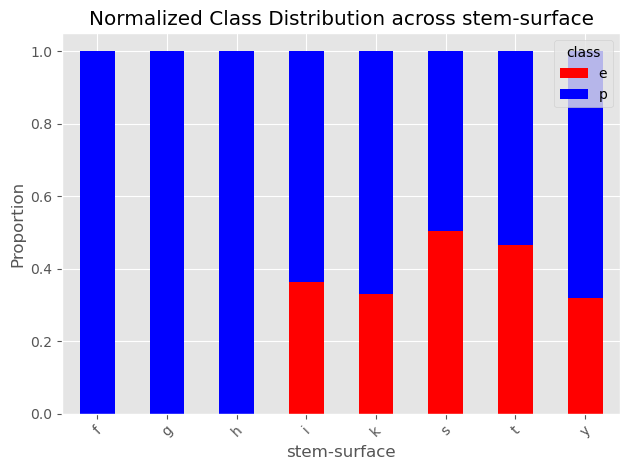

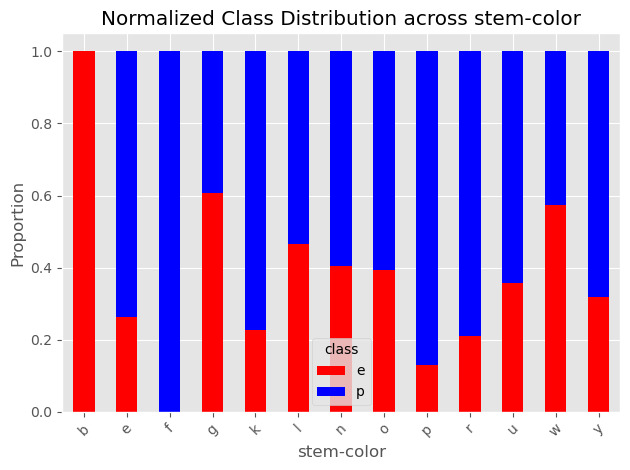

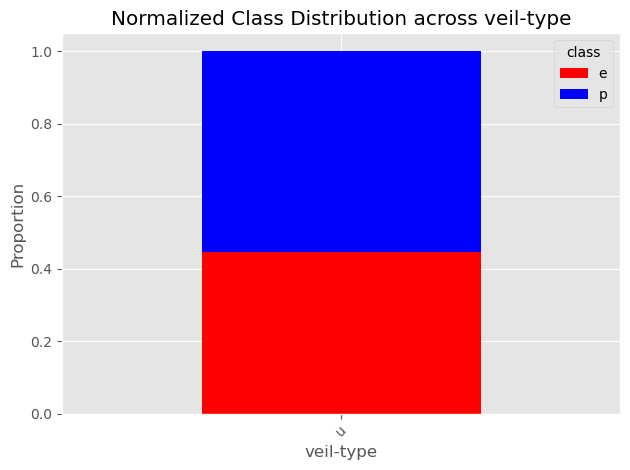

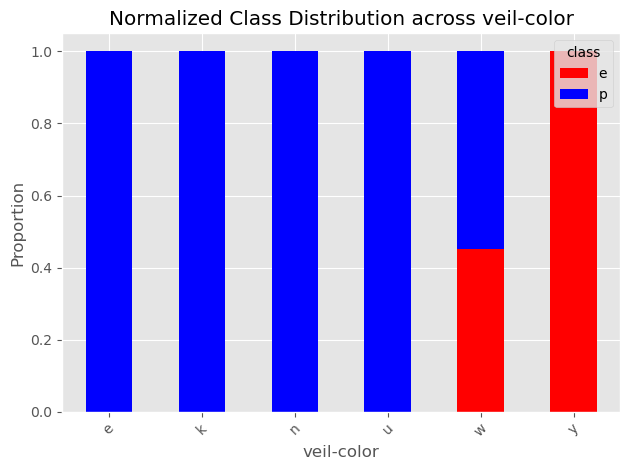

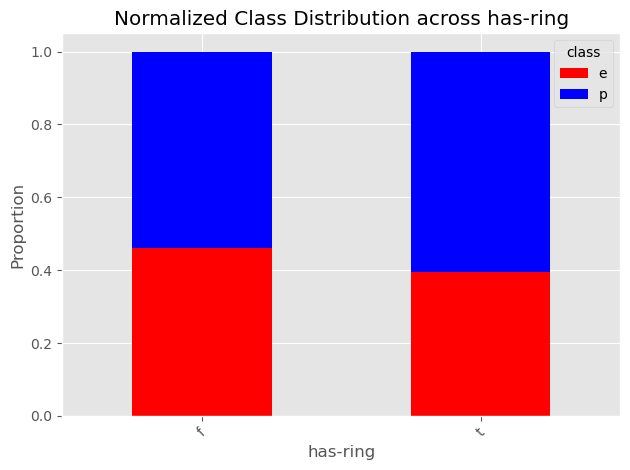

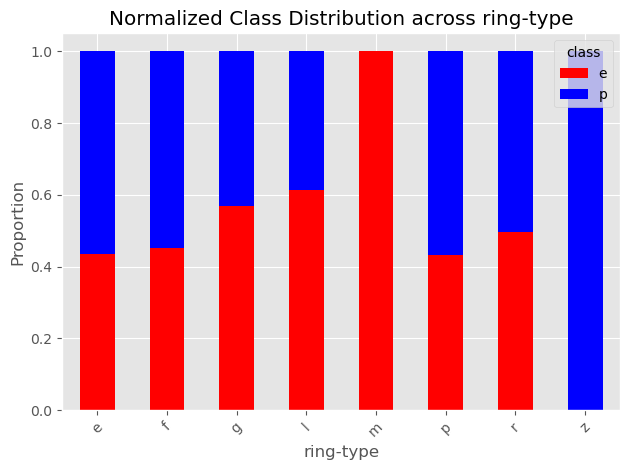

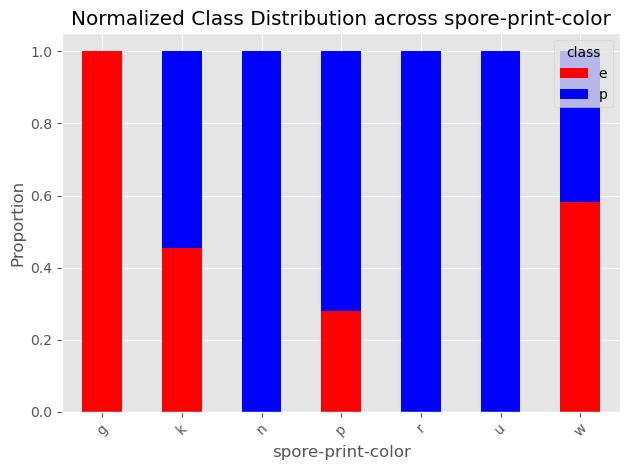

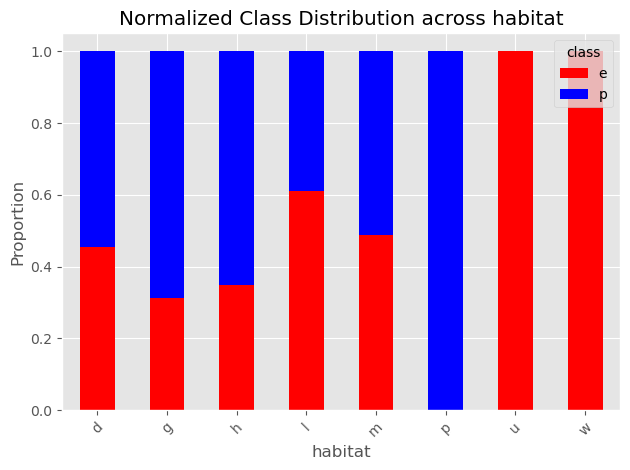

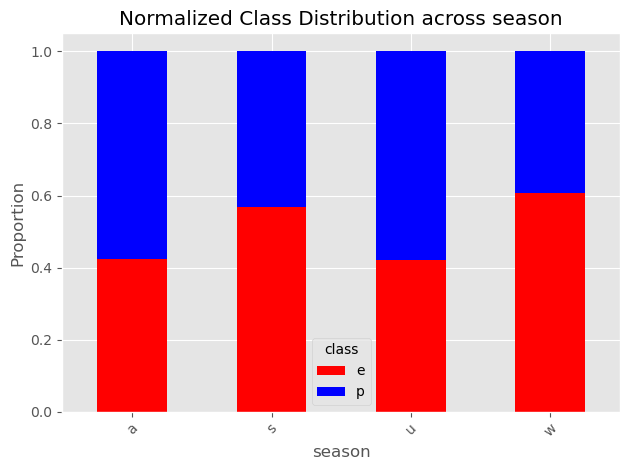

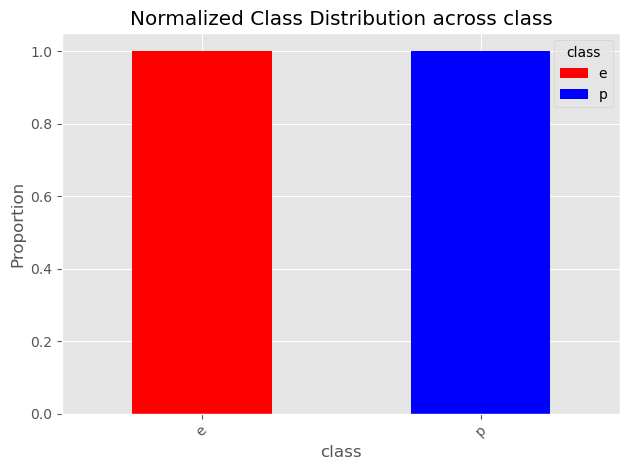

In [9]:
#Analysis of Proportinal relations
for column in categorical_columns:
    crosstab = pd.crosstab(data[column], data['class'], normalize='index')
    crosstab.plot(kind='bar', stacked=True, color=['red', 'blue'])
    plt.title(f'Normalized Class Distribution across {column}')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

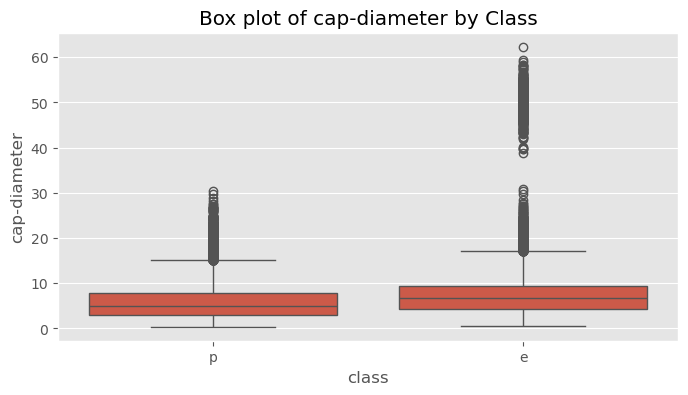

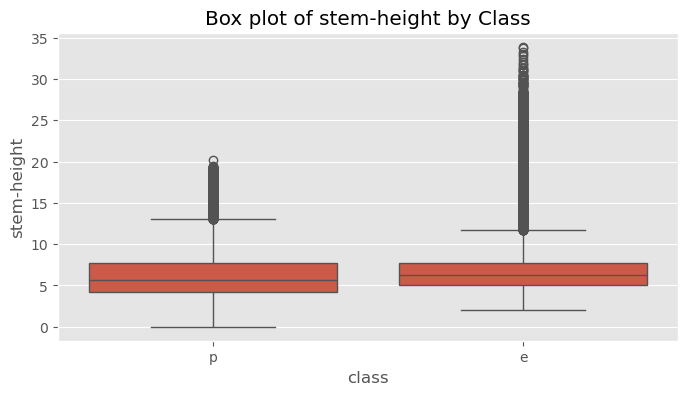

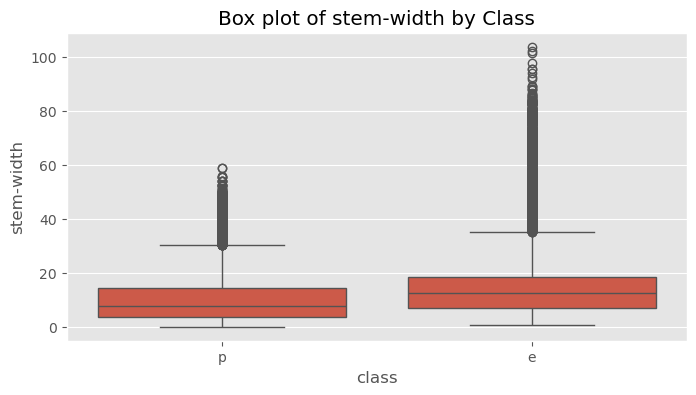

In [10]:
#Outliers
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='class', y=column, data=data)
    plt.title(f'Box plot of {column} by Class')
    plt.show()

# Data Cleaning

Missing data handling, catagorical and numerical

In [11]:
#Altough some of it was done before since it's a step 3 requirement
# Categorical data: Impute with the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_columns] = cat_imputer.fit_transform(data[categorical_columns])

# Numeric data: Impute with the median
num_imputer = SimpleImputer(strategy='median')
data[numeric_columns] = num_imputer.fit_transform(data[numeric_columns])

Removing outliers

In [12]:
for column in numeric_columns:
    z_scores = stats.zscore(data[column])
    data = data[(z_scores < 3) & (z_scores > -3)]

Reducing Impact of extreme outliers using cap values

In [13]:
for column in numeric_columns:
    upper_limit = data[column].quantile(0.99)
    lower_limit = data[column].quantile(0.01)
    data[column] = np.clip(data[column], lower_limit, upper_limit)

handling duplicates

In [14]:
#printing here
print(f"Duplicate entries: {data.duplicated().sum()}")

Duplicate entries: 207


In [15]:
#dropping here
data.drop_duplicates(inplace=True)
print(f"Duplicate entries: {data.duplicated().sum()}")

Duplicate entries: 0


label encoding

In [16]:
label_encoder = LabelEncoder()
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

Creating new column for unique values (one-hot encoding)

In [17]:
data = pd.get_dummies(data, columns=categorical_columns)

## Correlation with heatmap

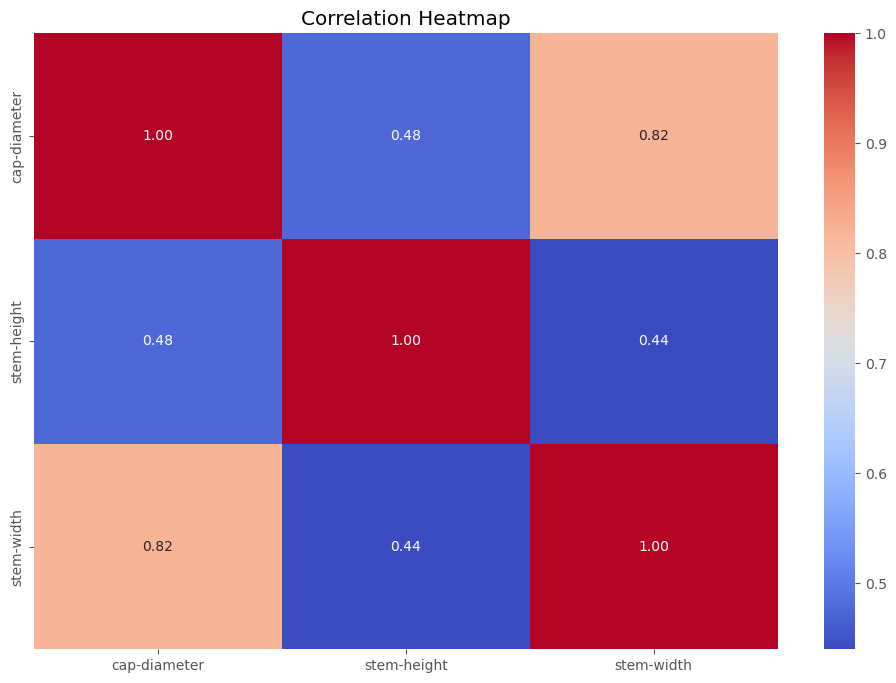

In [18]:
# Calculating the correlation matrix
corr_matrix = data.select_dtypes(include=['float64', 'int64']).corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Analyzing Catagorical values

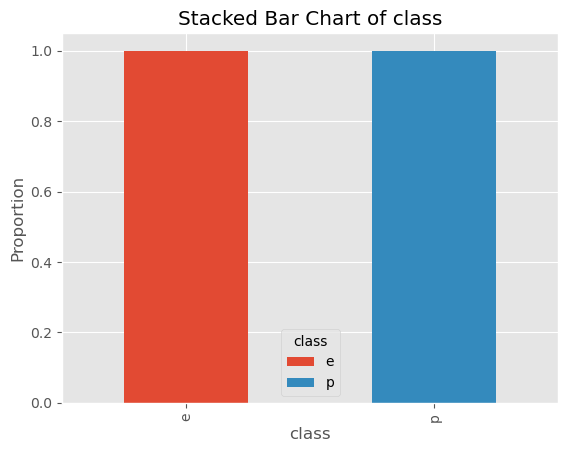

In [19]:
data['class'] = y
categorical_columns = data.select_dtypes(include=['object', 'category']).columns
for column in categorical_columns:
    pd.crosstab(data[column], data['class'], normalize='index').plot(kind='bar', stacked=True)
    plt.title(f'Stacked Bar Chart of {column}')
    plt.ylabel('Proportion')
    plt.show()

## Chi-square Test for Independence:

In [20]:
# Example chi-square test for a categorical feature
for column in categorical_columns:
    contingency_table = pd.crosstab(data[column], data['class'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test for {column}: p-value = {p}")

Chi-square test for class: p-value = 0.0


## Pair Plots for Mixed Data Types

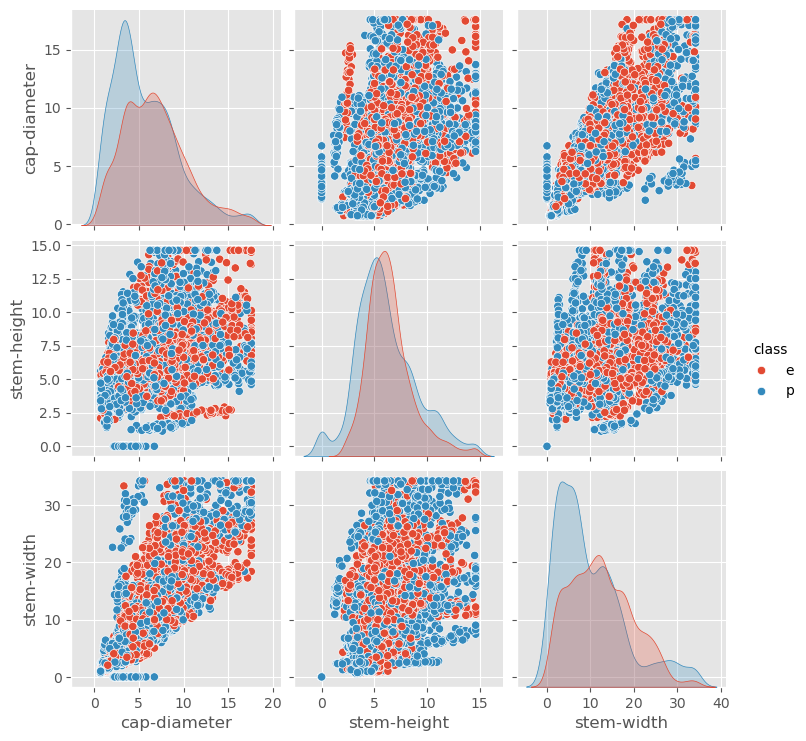

In [21]:

sampled_data = data.sample(frac=0.1) 

if 'class' in sampled_data.columns:
    sns.pairplot(sampled_data, hue='class', vars=numeric_columns)
    plt.show()
else:
    print("'class' column is not present in the sampled data.")

## Feature Importance from Model

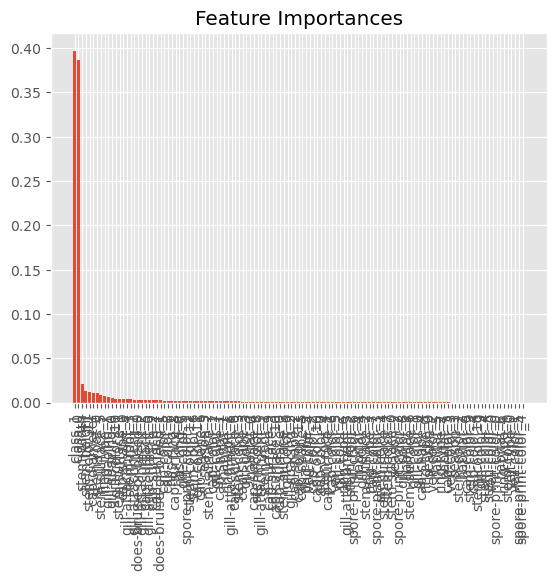

In [22]:
X = data.drop('class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Getting feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plotting Feature Importances
plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

## Information Gain and Mutual Information

In [23]:
# Calculating mutual information
mi_scores = mutual_info_classif(X_train, y_train)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Displaying scores
print(mi_scores)

class_1         0.692052
class_0         0.689217
stem-width      0.058186
stem-height     0.034027
cap-diameter    0.024772
                  ...   
cap-shape_5     0.000000
cap-color_11    0.000000
ring-type_0     0.000000
cap-color_2     0.000000
gill-color_4    0.000000
Name: MI Scores, Length: 121, dtype: float64


## Preparing data

In [24]:
X = data.drop('class', axis=1)  # Features
y = data['class']  # Target variable

Splitting the Dataset

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Checking Stratification of dataset

In [26]:
print("Original class distribution:")
print(y.value_counts(normalize=True))  # Shows the proportion of each class in the full dataset

print("\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))  # Proportion in the training set

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))  # Proportion in the test set

Original class distribution:
class
p    0.565372
e    0.434628
Name: proportion, dtype: float64

Training set class distribution:
class
p    0.565376
e    0.434624
Name: proportion, dtype: float64

Test set class distribution:
class
p    0.565355
e    0.434645
Name: proportion, dtype: float64


# Model Selection and Traning

Decision Tree accuracy

In [27]:
# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model
dt_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_classifier.predict(X_test)

# Evaluate the model
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {dt_accuracy}")

Decision Tree Accuracy: 1.0


RandomForest accuracy

In [28]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 1.0


Nural Network accuracy

In [36]:
# Ensure the data type is float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Check for any null values in the arrays
if np.isnan(X_train).any() or np.isnan(X_test).any():
    print("Null values found in training or testing set.")
    # Handling null values by filling them with zero
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)

In [37]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Sample data from X_train:", X_train[0])

X_train shape: (46760, 121)
X_test shape: (11690, 121)
Sample data from X_train: [ 7.86  7.62 14.45  0.    0.    0.    0.    0.    0.    1.    0.    0.
  1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    1.    0.    0.    0.    0.    0.    0.    1.    0.    0.
  0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    1.    0.    1.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    1.
  0.    0.    0.    0.    1.    0.    0.    1.    0.    0.    0.    0.
  0.    1.    0.    0.    0.    1.    0.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
  1.  ]


In [38]:
# Redefining and recompiling the model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
try:
    history = nn_model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.2)
except Exception as e:
    print("An error occurred during training:", e)

# Evaluate the model
try:
    nn_loss, nn_accuracy = nn_model.evaluate(X_test, y_test)
    print(f"Neural Network Accuracy: {nn_accuracy}")
except Exception as e:
    print("An error occurred during evaluation:", e)


Epoch 1/10
3741/3741 [==============================] - 8s 2ms/step - loss: 0.0158 - accuracy: 0.9951 - val_loss: 1.5681e-06 - val_accuracy: 1.0000
Epoch 2/10
3741/3741 [==============================] - 7s 2ms/step - loss: 5.7934e-07 - accuracy: 1.0000 - val_loss: 1.5512e-07 - val_accuracy: 1.0000
Epoch 3/10
3741/3741 [==============================] - 7s 2ms/step - loss: 6.7574e-08 - accuracy: 1.0000 - val_loss: 2.3476e-08 - val_accuracy: 1.0000
Epoch 4/10
3741/3741 [==============================] - 7s 2ms/step - loss: 1.2746e-08 - accuracy: 1.0000 - val_loss: 7.3415e-09 - val_accuracy: 1.0000
Epoch 5/10
3741/3741 [==============================] - 7s 2ms/step - loss: 5.8032e-09 - accuracy: 1.0000 - val_loss: 5.5531e-09 - val_accuracy: 1.0000
Epoch 6/10
3741/3741 [==============================] - 8s 2ms/step - loss: 4.3788e-09 - accuracy: 1.0000 - val_loss: 3.0623e-09 - val_accuracy: 1.0000
Epoch 7/10
3741/3741 [==============================] - 8s 2ms/step - loss: 3.6264e-09 - acc

## Comments

1. Decision Trees are chosen for their simplicity and interpretability, which is essential when you need a fast and understandable model.
2. Random Forests are used when accuracy is more critical, and the dataset has enough features and complexity to benefit from an ensemble method, but where you still desire some level of interpretability.
3. Neural Networks are selected for their ability to handle very complex patterns and large datasets, particularly when computational resources and data volume justify their use over simpler methods.

# Model Evaluation and Comparison

Decision Tree Evaluation

In [55]:
# Initialize and fit the LabelEncoder with the known class labels
encoder = LabelEncoder()
encoder.fit(['e', 'p'])  # Adjust labels as appropriate for your dataset

# Now check if the predicted labels need to be transformed
if isinstance(y_pred_dt[0], str):
    y_pred_dt_numeric = encoder.transform(y_pred_dt)  # Transform labels to numeric
else:
    y_pred_dt_numeric = y_pred_dt  # Assuming y_pred_dt is already numeric

# Calculate metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt_numeric)
precision_dt = precision_score(y_test, y_pred_dt_numeric)
recall_dt = recall_score(y_test, y_pred_dt_numeric)
f1_dt = f1_score(y_test, y_pred_dt_numeric)

print(f"Decision Tree - Accuracy: {accuracy_dt}")
print(f"Decision Tree - Precision: {precision_dt}")
print(f"Decision Tree - Recall: {recall_dt}")
print(f"Decision Tree - F1 Score: {f1_dt}")


Decision Tree - Accuracy: 1.0
Decision Tree - Precision: 1.0
Decision Tree - Recall: 1.0
Decision Tree - F1 Score: 1.0


RandomForest Evalutation

In [56]:
# If the classes are not ['e', 'p'], refit the encoder
if set(encoder.classes_) != {'e', 'p'}:
    encoder = LabelEncoder()
    encoder.fit(['e', 'p'])  # Assume 'e' and 'p' are your only classes
# Ensure y_pred_rf is an array or list of labels and transform it
if isinstance(y_pred_rf[0], str):
    y_pred_rf_numeric = encoder.transform(y_pred_rf)
else:
    raise ValueError("Predicted labels are not in expected string format.")
accuracy_rf = accuracy_score(y_test, y_pred_rf_numeric)
precision_rf = precision_score(y_test, y_pred_rf_numeric)
recall_rf = recall_score(y_test, y_pred_rf_numeric)
f1_rf = f1_score(y_test, y_pred_rf_numeric)

print(f"Random Forest - Accuracy: {accuracy_rf}, Precision: {precision_rf}, Recall: {recall_rf}, F1 Score: {f1_rf}")


Random Forest - Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1 Score: 1.0


Neural Network Evaluation

In [57]:
# Predict classes (binary classification)
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype("int32")

# Calculate metrics
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)

print(f"Neural Network - Accuracy: {nn_accuracy}, Precision: {precision_nn}, Recall: {recall_nn}, F1 Score: {f1_nn}")


366/366 [==============================] - 0s 1ms/step
Neural Network - Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1 Score: 1.0


Confusion matrix evaluation

366/366 [==============================] - 0s 1ms/step


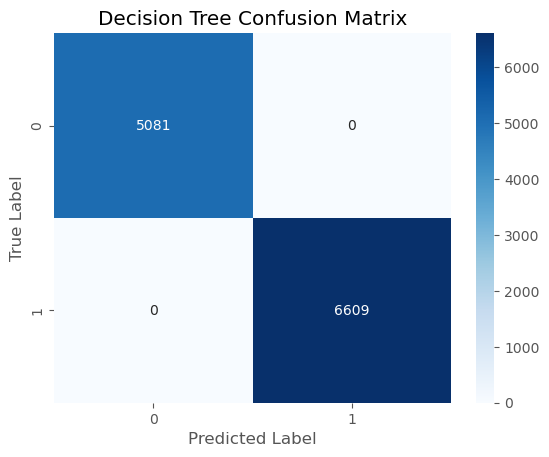

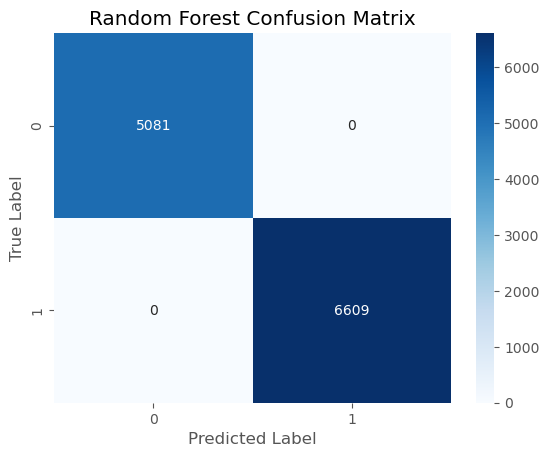

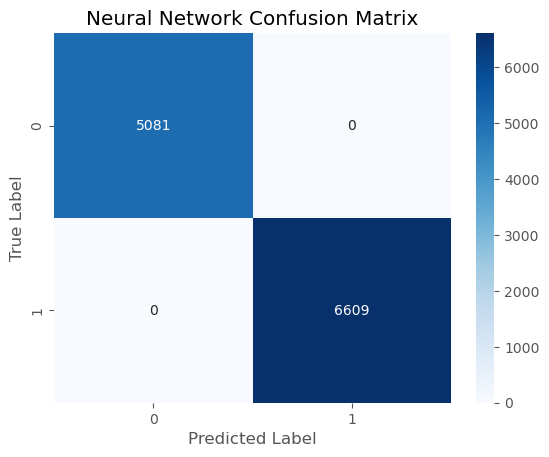

In [52]:
# Convert categorical predictions to numeric
y_pred_dt_numeric = encoder.transform(y_pred_dt)  # For Decision Tree
y_pred_rf_numeric = encoder.transform(y_pred_rf)  # For Random Forest
y_pred_nn_numeric = (nn_model.predict(X_test) > 0.5).astype(int)  # For Neural Network (assuming binary classification)
# Redefine the function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Plot confusion matrices for each model with numeric predictions
plot_confusion_matrix(y_test, y_pred_dt_numeric, title='Decision Tree Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_rf_numeric, title='Random Forest Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_nn_numeric, title='Neural Network Confusion Matrix')


Since all the models give accuracy 1, it states that they are performing excetionally well. In such cases we Check for Over Fitting, and chech if dataset includes noise and realistic scenarios. It could also be the case that data is quite simple and easy to predict.

# Model Optimization

For Neural Network

In [64]:
input_features = X_train.shape[1]  # Number of columns in X_train represents the number of features
# Initialize the model
model = Sequential()

# Adding a layer with L1 regularization
# Replace `input_features` with the actual number of input features determined above
model.add(Dense(64, activation='relu', kernel_regularizer=l1(0.01), input_shape=(input_features,)))
# Add a dropout layer for regularization
model.add(Dropout(0.5))

# Adding more layers (if necessary)
model.add(Dense(32, activation='relu'))

# Output layer - adjust according to the number of outputs and activation function suitable for your task
# For binary classification use 1 unit with sigmoid, for multi-class classification use softmax
model.add(Dense(1, activation='sigmoid'))  # Change the units and activation based on your specific problem
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1169/1169 [==============================] - 3s 2ms/step - loss: 0.6287 - accuracy: 0.9567 - val_loss: 0.0625 - val_accuracy: 1.0000
Epoch 2/10
1169/1169 [==============================] - 2s 2ms/step - loss: 0.0680 - accuracy: 0.9977 - val_loss: 0.0673 - val_accuracy: 1.0000
Epoch 3/10
1169/1169 [==============================] - 2s 2ms/step - loss: 0.0700 - accuracy: 0.9960 - val_loss: 0.0915 - val_accuracy: 1.0000
Epoch 4/10
1169/1169 [==============================] - 3s 2ms/step - loss: 0.0629 - accuracy: 0.9970 - val_loss: 0.0448 - val_accuracy: 1.0000
Epoch 5/10
1169/1169 [==============================] - 3s 2ms/step - loss: 0.0596 - accuracy: 0.9966 - val_loss: 0.0515 - val_accuracy: 1.0000
Epoch 6/10
1169/1169 [==============================] - 3s 2ms/step - loss: 0.0662 - accuracy: 0.9957 - val_loss: 0.0428 - val_accuracy: 1.0000
Epoch 7/10
1169/1169 [==============================] - 3s 2ms/step - loss: 0.0606 - accuracy: 0.9968 - val_loss: 0.0393 - val_accuracy:

for decision tree and RF

In [72]:
# Feature Importance
rf = RandomForestClassifier().fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Select the top k important features, for example
k = 10
X_train_reduced = X_train[:, indices[:k]]
X_test_reduced = X_test[:, indices[:k]]
estimator = RandomForestClassifier()
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

#Recursive Feature Elimination (RFE):
estimator = RandomForestClassifier()
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

Decision tree limiting growth

In [68]:
# Limit max_depth and min_samples_leaf
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=4)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=4)

RF limit growth

In [69]:
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=4, n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=4)

Grid search CV

In [73]:
param_grid = {
  'max_depth': [3, 5, 10],
  'min_samples_split': [2, 5, 10],
  'n_estimators': [50, 100, 200]  # Only for RandomForest
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

Random Search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
  'max_depth': [3, None],
  'min_samples_split': randint(2, 11),
  'n_estimators': randint(50, 200)  # Only for RandomForest
}

random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, n_iter=20, cv=5)
random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)
